# Self Organizing Map

In [53]:
# !pip install MiniSom

In [54]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import bone, pcolor, colorbar, plot, show
import pylab as pl

## Importing the dataset

This dataset contains information about customers who applied for a credit card. 0 means  rejected and 1 means approved.
Our goal is to detect the outliers, i.e the approved customers who are potentially fraudulent.

Since SOMs are unsupervised, we won't use the labels for training. Instead, they will compared to the SOM results.

In [55]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
features = dataset.iloc[:, :-1].values 
labels = dataset.iloc[:, -1].values

In [56]:
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  690 non-null    int64  
 1   A1          690 non-null    int64  
 2   A2          690 non-null    float64
 3   A3          690 non-null    float64
 4   A4          690 non-null    int64  
 5   A5          690 non-null    int64  
 6   A6          690 non-null    int64  
 7   A7          690 non-null    float64
 8   A8          690 non-null    int64  
 9   A9          690 non-null    int64  
 10  A10         690 non-null    int64  
 11  A11         690 non-null    int64  
 12  A12         690 non-null    int64  
 13  A13         690 non-null    int64  
 14  A14         690 non-null    int64  
 15  Class       690 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 86.4 KB
None


,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


## Feature Scaling


In [57]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
features = sc.fit_transform(features)

In [58]:
features[0]

array([0.84268147, 1.        , 0.12526316, 0.40928571, 0.5       ,
       0.23076923, 0.375     , 0.05561404, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.05      , 0.01212   ])

## Training the SOM


According to the doc, a general rule of thumb to set the size of the grid for a dimensionality reduction task is that it should contain 5 * sqrt(N) neurons where N is the number of samples.

Our map_size will be sqrt(5 * 690) = 58
map_size = map_height * map_width = (12, 12)

In [59]:
map_size = 5 * math.sqrt(len(features))
map_height = map_width = math.ceil(math.sqrt(map_size))

In [60]:
print(f'(map_height, map_width) = ({map_height}, {map_width})')
print(f'Number of features: {features.shape[1]}')

(map_height, map_width) = (12, 12)
Number of features: 15


In [61]:
from minisom import MiniSom

som = MiniSom(x=map_height, y=map_width, input_len=features.shape[1], sigma=1.0, learning_rate=0.5,
               topology='hexagonal', random_seed=123)
som.random_weights_init(features)
som.train_random(data = features, num_iteration = 100)

## Understanding the results

The wining node is the one that is the closest to the input feature Xi.
We can get its coordinates (x, y) on the map by using the winner() method.

In [62]:
som.winner(features[0])

(9, 8)

The distance map is a 2D array (12x12) where each element represents the average distance between a neuron and its neighbors.

In [63]:
print('-------------\nDistance Map\n------------')
print(f'Shape: {som.distance_map().shape}')
print(f'First Line: {som.distance_map().T[0]}')

-------------
Distance Map
------------
Shape: (12, 12)
First Line: [0.17511248 0.3471176  0.31250851 0.50742247 0.47147037 0.57784171
 0.69111328 0.7003696  0.59045295 0.50168131 0.47053189 0.29468357]


The frequencies is a 2D array where each neuron at (x,y) is the number of time the neuron was winner
E.g: neuron located at (2, 5) may contains 7 

In [64]:
frequencies = som.activation_response(features)
print(f'Frequencies:\n {np.array(frequencies, np.uint)}')

Frequencies:
 [[ 2  1 10  3  3  5  6  4  0  5  8  5]
 [23  0  1  4  7  5  5  0  7  0  4  0]
 [ 0  0  0  8  2  3  3  3  0  0  7  5]
 [11  3  4 18  2  1 13  0  2  3  5  6]
 [ 8  0  1  3  8  0  2  0  9  3  4  2]
 [23 15 16  7  4  6  2  0 14  5  1 16]
 [15  7  4  7  0  3  1  3 11  6  6  0]
 [ 3  3  5  2  4  0  8  4  2  0  2  3]
 [11  3  5  9  0  0  1  6  2  2  3 10]
 [ 3  4  2  0  2  9  0  1  9  6  0  0]
 [ 8  3  5 19  0  0  0 17  7  8  9 11]
 [ 6  1  5  0  1 15  6  5  1  4  8  8]]


## Visualizing the results


### Helper functions

In [65]:
def plot_distance_map(ax, fig):
    """Plot the distance map"""
    p = ax.pcolor(som.distance_map().T, cmap='bone_r') # cmap='Blues'
    # ax.colorbar()
    fig.colorbar(p, ax=ax)

In [66]:
def plot_clusters_scatter(ax):
    """
    Create a scatter plot of the winning neurons. 
    Each neuron is assigned the color of the cluster it belongs to.
    """ 
    # Get the winning neuron coordinates for each sample 
    # The coordinates are transformed into an array for the scatter plot: (1,1) => [1,1]
    winning_neurons = np.array([som.winner(x) for x in features])

    # Add a random offset to avoid overlaps between points within the same cell
    offset = np.random.uniform(low=-0.4, high=0.4, size=(len(features), 2))
    winning_neurons = winning_neurons + offset

    # Define the colors based on the labels
    colors = ['#ff0400', 'g']
    label_colors = [colors[label] for label in labels]

    # Create the scatter plot
    # 1st column represent x and second, y coordinate
    ax.scatter(winning_neurons[:,0], winning_neurons[:,1], s=10, c=label_colors)
    

In [67]:
def plot_clusters_markers(ax):
    """
    Plot the winning neurons as markers.
    Each marker is assigned the color of the cluster ir belongs to.
    """
    markers = ['s', '^']
    colors = ['#ff0400', 'g']
    for i, feature in enumerate(features):
        w = som.winner(feature)
        ax.plot(w[0] + 0.5, w[1] + 0.5, 
            markers[labels[i]], markeredgecolor = colors[labels[i]], 
            markerfacecolor = 'None', markersize = 10, markeredgewidth = 1)
        
    # legend
    ax.legend(handles=[plt.Line2D([], [], color='#ff0400', marker='^', linestyle='None', label='Rejected'),
                    plt.Line2D([], [], color='green', marker='s', linestyle='None', label='Approved')],
                    bbox_to_anchor=(1.5, 1.03))

### Distance Map, points, clusters

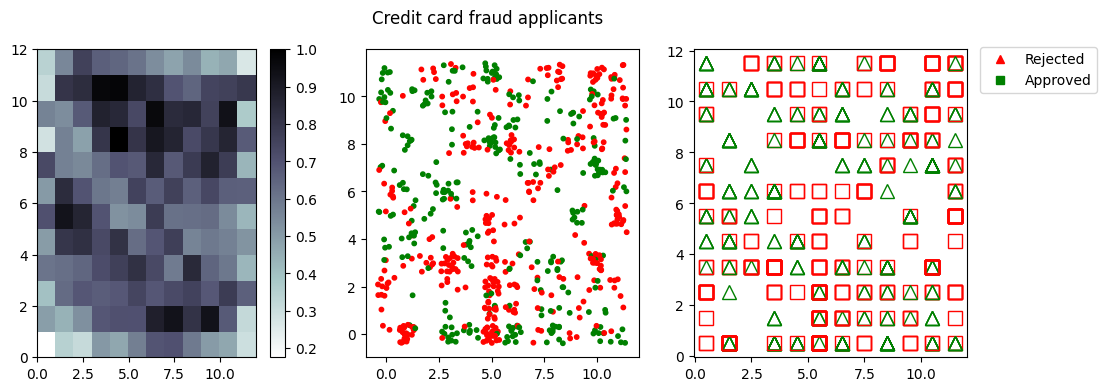

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_distance_map(axes[0], fig)
plot_clusters_scatter(axes[1])
plot_clusters_markers(axes[2])

plt.suptitle("Credit card fraud applicants")
plt.show()

## Conclusion
The light shades represent the clusters whereas the darkers ones are the separation beteen these clusters. However, the SOM clusters that are very different from the two types of applications (approved and rejected). Our SOM is not able to capture 

There are several potential reasons for this failure:

1. Insufficient or irrelevant features: The features might not be the most relevant ones for distinguishing between approved and rejected applications. 
2. Hyperparameter tuning: number of nodes, learning rate, neighborhood size, and training iterations might be optimized.
3. Complex decision boundaries: Credit card approval decisions often involve complex decision boundaries that are not easily captured by simple clustering algorithms like SOM.

## Finding the frauds
Proposed by Hadelin de Ponteves from the course [Deep Learning A-Z](https://www.udemy.com/course/deeplearning/learn/lecture/6744694#overview), this section might requires additional analysis to make sure the interpretations are correct.

win_map returns a dictionary where ech key is the coordinates and each value is an array of all the corresponding input features.
E.g: { (6, 2): [ [0.84, ..., 0.012   ], ..., [0.81, ..., 0.17] ] }

Look at the map, and you get can get visually infer the coordinates that contain data.
E.g.: (x,y) = (2,5)

In [79]:
mappings = som.win_map(features)
print(list(mappings.items())[0])

((9, 8), [array([0.84268147, 1.        , 0.12526316, 0.40928571, 0.5       ,
       0.23076923, 0.375     , 0.05561404, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.05      , 0.01212   ]), array([0.72114172, 1.        , 0.15533835, 0.32142857, 0.5       ,
       0.38461538, 0.375     , 0.00877193, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.        , 0.        ]), array([0.98014648, 1.        , 0.30706767, 0.09821429, 0.5       ,
       0.15384615, 0.5       , 0.0877193 , 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.116     , 0.002     ]), array([0.89100585, 1.        , 0.09398496, 0.39446429, 0.5       ,
       0.53846154, 0.375     , 0.07017544, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0.068     , 0.        ]), array([0.59042402, 1.        , 0.20556391, 0.44642857, 0.5       ,
       0.38461538, 0.5       , 0.00877193, 0.        , 0.        ,
       0.        , 1.        , 0.5       , 0

In [70]:
frauds = mappings[(8, 7)]
frauds

[array([0.13505039, 1.        , 0.67413534, 0.09678571, 0.5       ,
        0.53846154, 0.375     , 0.08473684, 0.        , 0.        ,
        0.        , 1.        , 0.5       , 0.16      , 0.        ]),
 array([0.20068955, 1.        , 0.30706767, 0.1875    , 0.5       ,
        0.61538462, 0.375     , 0.00298246, 0.        , 0.        ,
        0.        , 1.        , 0.5       , 0.145     , 0.00006   ]),
 array([0.11651831, 1.        , 0.2793985 , 0.08928571, 0.5       ,
        0.53846154, 0.375     , 0.04385965, 0.        , 0.        ,
        0.        , 1.        , 0.5       , 0.14      , 0.        ]),
 array([0.46368263, 1.        , 0.50496241, 0.23214286, 0.5       ,
        0.53846154, 0.375     , 0.03508772, 0.        , 0.        ,
        0.        , 1.        , 0.5       , 0.        , 0.00228   ]),
 array([0.1012938 , 1.        , 0.5124812 , 0.14875   , 0.5       ,
        1.        , 0.5       , 0.00298246, 0.        , 0.        ,
        0.        , 1.        , 0.5     

In [71]:
np.set_printoptions(suppress=True)
frauds = sc.inverse_transform(frauds)
frauds

array([[15599440.   ,        1.   ,       58.58 ,        2.71 ,
               2.   ,        8.   ,        4.   ,        2.415,
               0.   ,        0.   ,        0.   ,        1.   ,
               2.   ,      320.   ,        1.   ],
       [15615832.   ,        1.   ,       34.17 ,        5.25 ,
               2.   ,        9.   ,        4.   ,        0.085,
               0.   ,        0.   ,        0.   ,        1.   ,
               2.   ,      290.   ,        7.   ],
       [15594812.   ,        1.   ,       32.33 ,        2.5  ,
               2.   ,        8.   ,        4.   ,        1.25 ,
               0.   ,        0.   ,        0.   ,        1.   ,
               2.   ,      280.   ,        1.   ],
       [15681509.   ,        1.   ,       47.33 ,        6.5  ,
               2.   ,        8.   ,        4.   ,        1.   ,
               0.   ,        0.   ,        0.   ,        1.   ,
               2.   ,        0.   ,      229.   ],
       [15591010.   ,       

## Printing a Fraunch Client

In [72]:
frauds[0]

array([15599440.   ,        1.   ,       58.58 ,        2.71 ,
              2.   ,        8.   ,        4.   ,        2.415,
              0.   ,        0.   ,        0.   ,        1.   ,
              2.   ,      320.   ,        1.   ])